<a href="https://colab.research.google.com/github/kuzmatsukanov/kuzma_omri_noa_data_project/blob/main/image_identification_noa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocessing import Pool
from functools import partial


from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

For multiprocessing later on:

In [2]:
img_size = 80

In [3]:
def load_image(image_path, resize_shape=None):
    img = cv2.imread(image_path)
    if resize_shape is not None:
        img = cv2.resize(img, resize_shape)
    return img

def load_images_parallel(image_paths, n_jobs=4, resize_shape=None):
    with Pool(processes=n_jobs) as pool:
        func = partial(load_image, resize_shape=resize_shape)
        images = pool.map(func, image_paths)
    return np.array(images)

Mount the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/ds_project_dataset'

!cp -r "$shared_folder_path" .

Mounted at /content/drive


Dataframe

In [5]:
df = pd.read_csv('ds_project_dataset/articles.csv')

In [6]:
df.sample(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
92638,854678005,854678,C Lolly Bandeau,298,Bikini top,Swimwear,1010026,Other structure,61,Light Purple,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Lined, bandeau bikini top with side support an..."
93191,857227001,857227,Cambridge dress,265,Dress,Garment Full body,1010016,Solid,93,Dark Green,...,Dress,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1013,Dresses Ladies,"Short, straight-cut dress in satin with a boat..."
5428,495725005,495725,BD check Gerald,259,Shirt,Garment Upper body,1010004,Check,43,Dark Red,...,Shirt,F,Menswear,3,Menswear,23,Men Suits & Tailoring,1011,Shirts,Shirt in a cotton weave with a button-down col...
100147,888552001,888552,Ajax sandal,91,Sandals,Shoes,1010001,All over pattern,10,White,...,Baby Shoes,G,Baby Sizes 50-98,4,Baby/Children,42,Kids & Baby Shoes,1020,Shoes,"Sturdy sandals with a hook and loop fastening,..."
19957,586336013,586336,Alejandro Jogger,272,Trousers,Garment Lower body,1010005,Colour blocking,9,Black,...,Jersey Fancy,F,Menswear,3,Menswear,55,Contemporary Street,1005,Jersey Fancy,Sports trousers in fabric with a slight sheen....


In [7]:
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [8]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [9]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Lilac Purple',
       'Red', 'Mole', 'Orange', 'Metal', 'Brown', 'Turquoise', 'Yellow',
       'Khaki green', 'Green', 'undefined', 'Unknown', 'Yellowish Green',
       'Bluish Green'], dtype=object)

In [10]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

In [11]:
df['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

Relevant categories

In [12]:
selected_categories = ['Garment Upper body', 'Underwear', 'Socks & Tights', 'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags']
df = df[df['product_group_name'].isin(selected_categories)]

In [13]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Shoes', 'Garment Full body', 'Bags'],
      dtype=object)

In [14]:
selected_categories = ['undefined', 'Unknown']
df = df[~df['perceived_colour_master_name'].isin(selected_categories)]

In [15]:
df['perceived_colour_master_name'] = df['perceived_colour_master_name'].replace(['Khaki green', 'Yellowish Green', 'Bluish Green', 'Lilac Purple'], ['Green', 'Green', 'Green', 'Purple'])

<ipython-input-15-c4bef705f818>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perceived_colour_master_name'] = df['perceived_colour_master_name'].replace(['Khaki green', 'Yellowish Green', 'Bluish Green', 'Lilac Purple'], ['Green', 'Green', 'Green', 'Purple'])


In [16]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Purple', 'Red',
       'Brown', 'Green', 'Yellow', 'Orange', 'Turquoise', 'Mole', 'Metal'],
      dtype=object)

In [17]:
selected_categories = ['Other pattern', 'Unknown', 'Other structure']
df = df[~df['graphical_appearance_name'].isin(selected_categories)]

In [18]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Denim',
       'Colour blocking', 'Dot', 'Contrast', 'Treatment', 'Check',
       'Mixed solid/pattern', 'Placement print', 'Glittering/Metallic',
       'Neps', 'Embroidery', 'Application/3D', 'Chambray', 'Lace',
       'Front print', 'Transparent', 'Jacquard', 'Argyle', 'Slub',
       'Metallic', 'Mesh', 'Sequin', 'Hologram'], dtype=object)

In [19]:
selected_categories = ['Ladieswear', 'Menswear', 'Divided']
df = df[df['index_group_name'].isin(selected_categories)]

In [20]:
df.shape

(54933, 25)

Baseline

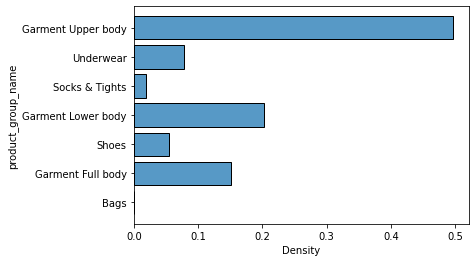

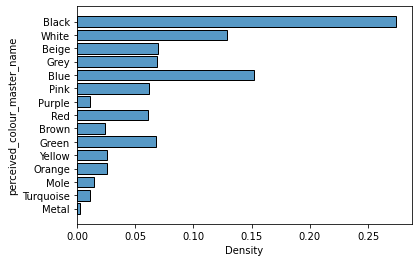

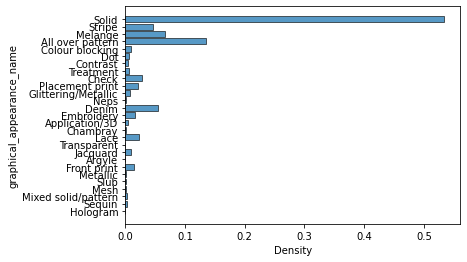

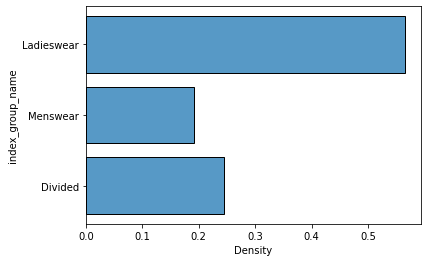

In [21]:
for feat in ['product_group_name', 'perceived_colour_master_name', 'graphical_appearance_name', 'index_group_name']:
  sns.histplot(y=df[feat], stat = 'density', shrink = 0.8, common_norm=False)
  plt.show()

In [22]:
df['subfolder'] = '0' + df['article_id'].astype(str).str[:2]
df['image_path'] = 'ds_project_dataset/images/' + df['subfolder'].str.strip() + '/0' + df['article_id'].astype(str) + '.jpg'

In [23]:
df['image_path']

0         ds_project_dataset/images/010/0108775015.jpg
1         ds_project_dataset/images/010/0108775044.jpg
2         ds_project_dataset/images/010/0108775051.jpg
3         ds_project_dataset/images/011/0110065001.jpg
4         ds_project_dataset/images/011/0110065002.jpg
                              ...                     
105536    ds_project_dataset/images/095/0952938001.jpg
105537    ds_project_dataset/images/095/0953450001.jpg
105538    ds_project_dataset/images/095/0953763001.jpg
105539    ds_project_dataset/images/095/0956217002.jpg
105541    ds_project_dataset/images/095/0959461001.jpg
Name: image_path, Length: 54933, dtype: object

In [24]:
df['image_path'][0]

'ds_project_dataset/images/010/0108775015.jpg'

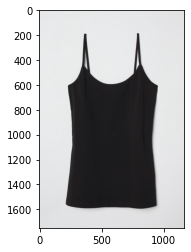

In [25]:
img = cv2.imread(df['image_path'][0])
plt.imshow(img)
plt.show()

In [26]:
import os

valid_images = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    if os.path.isfile(row['image_path']):
        valid_images.append(row)

df_valid_images = pd.DataFrame(valid_images)

100%|██████████| 54933/54933 [09:36<00:00, 95.34it/s]  


In [27]:
df_valid_images.shape

(44388, 27)

In [28]:
images = load_images_parallel(df_valid_images['image_path'].values, n_jobs=4, resize_shape=(img_size, img_size))

Encoding for the model

In [29]:
new_df = pd.DataFrame(df_valid_images['article_id'])

In [30]:
new_df

,article_id
0,108775015
1,108775044
2,108775051
3,110065001
4,110065002
...,...
87117,826164005
87118,826164006
87119,826164007
87120,826164009


In [31]:
new_df = new_df.join(pd.get_dummies(df_valid_images['perceived_colour_master_name'], prefix='colour'))
new_df = new_df.join(pd.get_dummies(df_valid_images['product_group_name'], prefix='product'))
new_df = new_df.join(pd.get_dummies(df_valid_images['graphical_appearance_name'], prefix='pattern'))
new_df = new_df.join(pd.get_dummies(df_valid_images['index_group_name'], prefix='index'))

In [32]:
new_df.sample(5)

,article_id,colour_Beige,colour_Black,colour_Blue,colour_Brown,colour_Green,colour_Grey,colour_Metal,colour_Mole,colour_Orange,...,pattern_Placement print,pattern_Sequin,pattern_Slub,pattern_Solid,pattern_Stripe,pattern_Transparent,pattern_Treatment,index_Divided,index_Ladieswear,index_Menswear
62460,736489002,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
50786,697315006,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
69775,758129003,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
66894,749377001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101,176209033,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
color_array = new_df.filter(like='colour_').to_numpy()
pattern_array = new_df.filter(like='pattern_').to_numpy()
type_array = new_df.filter(like='product_').to_numpy()
index_array = new_df.filter(like='index_').to_numpy()

In [34]:
new_df.filter(like='colour_').columns

Index(['colour_Beige', 'colour_Black', 'colour_Blue', 'colour_Brown',
       'colour_Green', 'colour_Grey', 'colour_Metal', 'colour_Mole',
       'colour_Orange', 'colour_Pink', 'colour_Purple', 'colour_Red',
       'colour_Turquoise', 'colour_White', 'colour_Yellow'],
      dtype='object')

In [35]:
new_df.filter(like='pattern_').columns

Index(['pattern_All over pattern', 'pattern_Application/3D', 'pattern_Argyle',
       'pattern_Chambray', 'pattern_Check', 'pattern_Colour blocking',
       'pattern_Contrast', 'pattern_Denim', 'pattern_Dot',
       'pattern_Embroidery', 'pattern_Front print',
       'pattern_Glittering/Metallic', 'pattern_Hologram', 'pattern_Jacquard',
       'pattern_Lace', 'pattern_Melange', 'pattern_Mesh', 'pattern_Metallic',
       'pattern_Mixed solid/pattern', 'pattern_Neps',
       'pattern_Placement print', 'pattern_Sequin', 'pattern_Slub',
       'pattern_Solid', 'pattern_Stripe', 'pattern_Transparent',
       'pattern_Treatment'],
      dtype='object')

In [55]:
list(new_df.filter(like='product_').columns)

['product_Bags',
 'product_Garment Full body',
 'product_Garment Lower body',
 'product_Garment Upper body',
 'product_Shoes',
 'product_Socks & Tights',
 'product_Underwear']

In [37]:
new_df.filter(like='index_').columns

Index(['index_Divided', 'index_Ladieswear', 'index_Menswear'], dtype='object')

In [38]:
color_array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

Splitting + Model

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_color_train, y_color_test, y_type_train, y_type_test, y_pattern_train, y_pattern_test, y_index_train, y_index_test = train_test_split(
    images, color_array, type_array, pattern_array, index_array, test_size=0.2, random_state=42)

X_train, X_val, y_color_train, y_color_val, y_type_train, y_type_val, y_pattern_train, y_pattern_val, y_index_train, y_index_val = train_test_split(
    X_train, y_color_train, y_type_train, y_pattern_train, y_index_train, test_size=0.25, random_state=42)


In [40]:
inputs = Input(shape=(img_size, img_size, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

color_output = Dense(len(df_valid_images['perceived_colour_master_name'].unique()), activation='softmax', name='color_output')(x)
type_output = Dense(len(df_valid_images['product_group_name'].unique()), activation='softmax', name='type_output')(x)
pattern_output = Dense(len(df_valid_images['graphical_appearance_name'].unique()), activation='softmax', name='pattern_output')(x)
index_output = Dense(len(df_valid_images['index_group_name'].unique()), activation='softmax', name='index_output')(x)

model = Model(inputs=inputs, outputs=[color_output, type_output, pattern_output, index_output])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 78, 78, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 39, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 37, 37, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [41]:
from keras.optimizers import Adam

In [42]:
model.compile(
    optimizer=Adam(),
    loss={
        'color_output': 'categorical_crossentropy',
        'type_output': 'categorical_crossentropy',
        'pattern_output': 'categorical_crossentropy',
        'index_output': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [43]:
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_pattern_output_accuracy',
    mode='max',
    save_best_only=True)

In [44]:
history = model.fit(
    X_train,
    {'color_output': y_color_train, 'type_output': y_type_train, 'pattern_output': y_pattern_train, 'index_output':y_index_train},
    validation_data=(
        X_val,
        {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val, 'index_output':y_index_val}
    ),
    epochs=40,
    batch_size=32,
    callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

scores = model.evaluate(
    X_test,
    {'color_output': y_color_test, 'type_output': y_type_test, 'pattern_output': y_pattern_test, 'index_output':y_index_test}
)

Epoch 1/40
833/833 [==============================] - 19s 12ms/step - loss: 5.5896 - color_output_loss: 1.5693 - type_output_loss: 1.0219 - pattern_output_loss: 1.8033 - index_output_loss: 1.1951 - color_output_accuracy: 0.6095 - type_output_accuracy: 0.7780 - pattern_output_accuracy: 0.6173 - index_output_accuracy: 0.6137 - val_loss: 3.4335 - val_color_output_loss: 0.9239 - val_type_output_loss: 0.4873 - val_pattern_output_loss: 1.2431 - val_index_output_loss: 0.7792 - val_color_output_accuracy: 0.7147 - val_type_output_accuracy: 0.8352 - val_pattern_output_accuracy: 0.6616 - val_index_output_accuracy: 0.6579
Epoch 2/40
833/833 [==============================] - 9s 11ms/step - loss: 3.2513 - color_output_loss: 0.8983 - type_output_loss: 0.4115 - pattern_output_loss: 1.2064 - index_output_loss: 0.7350 - color_output_accuracy: 0.7209 - type_output_accuracy: 0.8595 - pattern_output_accuracy: 0.6709 - index_output_accuracy: 0.6754 - val_loss: 3.1322 - val_color_output_loss: 0.8529 - val_t

In [45]:
print('Test Accuracy - Color: {:.2f}%, Type: {:.2f}%, Pattern: {:.2f}%, Index: {:.2f}%'.format(scores[5] * 100, scores[6] * 100, scores[7] * 100, scores[8] * 100))

Validation Accuracy - Color: 73.36%, Type: 87.94%, Pattern: 67.79%, Index: 70.73%


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

y_color_pred = np.argmax(y_pred[0], axis=1)
y_type_pred = np.argmax(y_pred[1], axis=1)
y_index_pred = np.argmax(y_pred[3], axis=1)

y_color_true = np.argmax(y_color_test, axis=1)
y_type_true = np.argmax(y_type_test, axis=1)
y_index_true = np.argmax(y_index_test, axis=1)

confusion_matrix_color = confusion_matrix(y_color_true, y_color_pred, normalize='true')
confusion_matrix_type = confusion_matrix(y_type_true, y_type_pred, normalize='true')
confusion_matrix_index = confusion_matrix(y_index_true, y_index_pred, normalize='true')

278/278 [==============================] - 1s 3ms/step


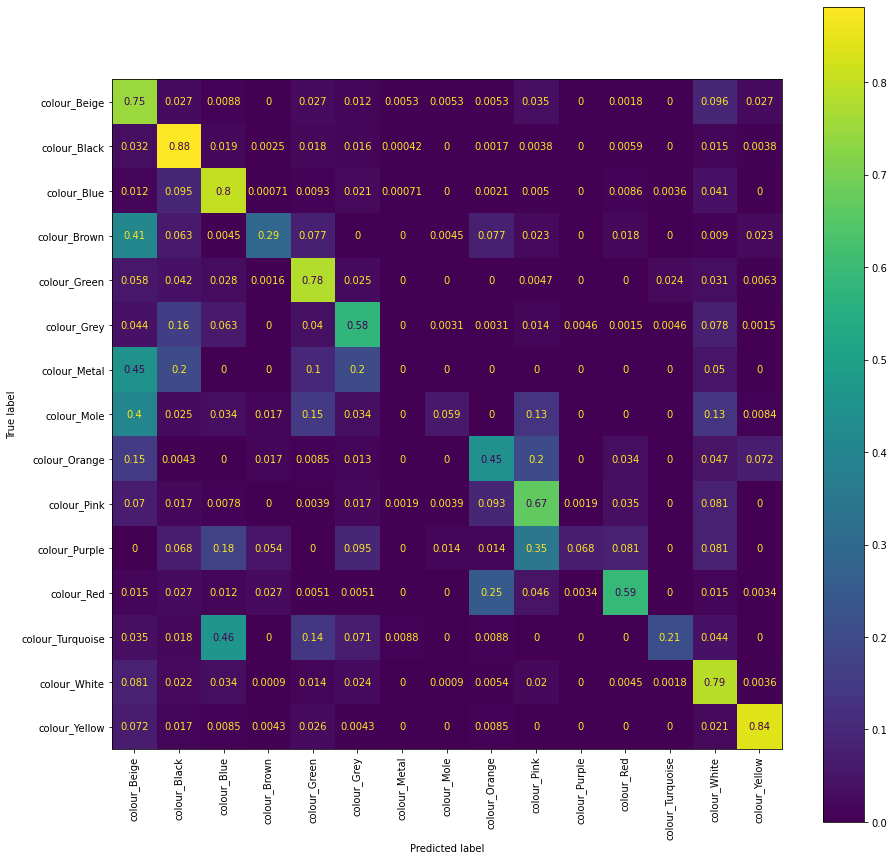

In [73]:
cmp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_color, display_labels=list(new_df.filter(like='colour_').columns))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

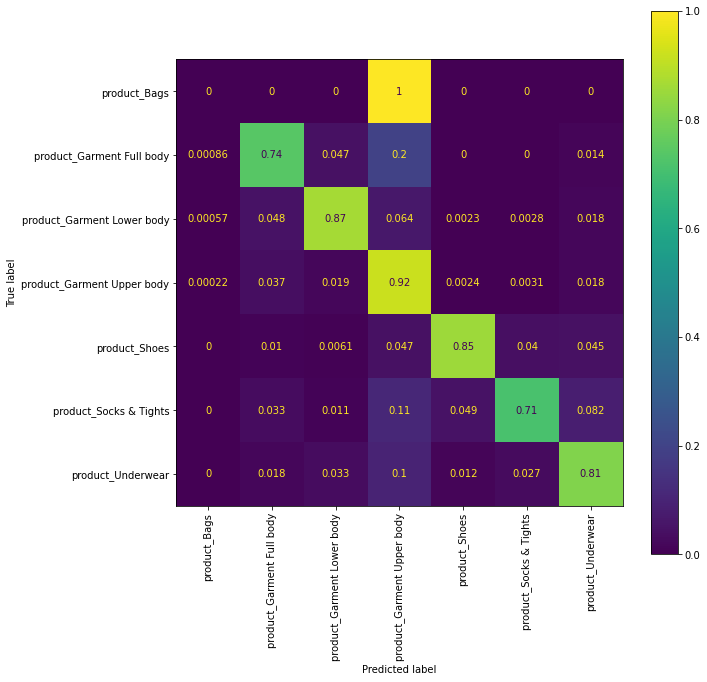

In [65]:
cmp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_type, display_labels=list(new_df.filter(like='product_').columns))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

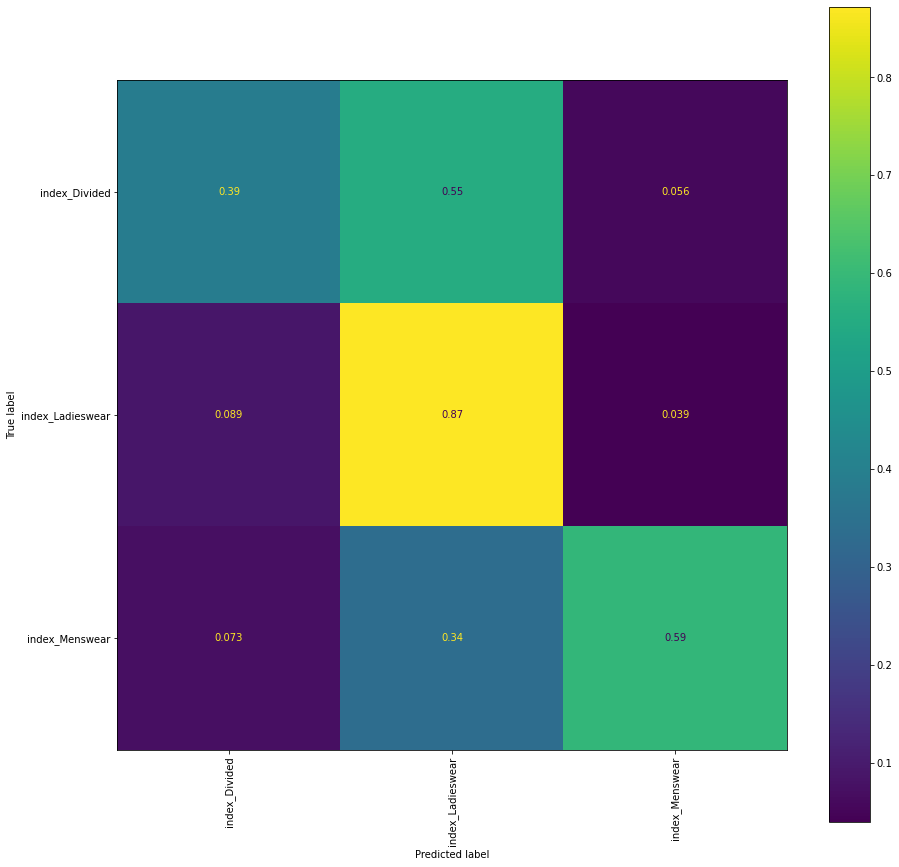

In [66]:
cmp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_index, display_labels=list(new_df.filter(like='index_').columns))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
model.save('my_model.h5')